In [3]:
import pickle

with open('./coms_with_weather_dataset.pkl','rb') as f:
    data = pickle.load(f)  

In [3]:
len(data)

25744

In [3]:
data[0][0]#촬영일시

'201102240000'

In [5]:
len(data[0][1])#영상데이터

3

In [16]:
data[0][1].shape

(3, 172, 200)

In [7]:
len(data[0][2])#기상데이터

112

In [6]:
list(data[0][2]) # 기상청 데이터 , 예시로 온도 , 기압 , 풍향 or기온

[78.2,
 32.1,
 57.0,
 77.2,
 69.8,
 78.3,
 76.5,
 55.0,
 62.1,
 79.6,
 75.6,
 76.9,
 48.7,
 82.8,
 75.7,
 75.7,
 34.0,
 27.0,
 20.0,
 20.0,
 25.0,
 29.0,
 32.0,
 27.0,
 29.0,
 16.0,
 0.0,
 0.0,
 25.0,
 16.0,
 20.0,
 0.0,
 2.0,
 7.0,
 2.0,
 3.0,
 12.0,
 1.0,
 1.0,
 5.0,
 2.0,
 1.0,
 0.0,
 0.0,
 8.0,
 1.0,
 3.0,
 0.0,
 1011.4,
 1013.4,
 1009.9,
 1012.1,
 990.3,
 1014.4,
 1013.2,
 1019.0,
 1013.4,
 1015.2,
 1014.9,
 1013.0,
 1010.9,
 1016.7,
 1012.2,
 1018.0,
 1021.2,
 1016.6,
 1020.5,
 1020.7,
 1016.8,
 1021.5,
 1021.1,
 1019.2,
 1020.5,
 1022.8,
 1019.2,
 1022.3,
 1019.3,
 1021.3,
 1021.2,
 1020.4,
 -4.6,
 -6.6,
 -3.0,
 -0.3,
 3.3,
 -0.8,
 -1.7,
 -0.2,
 -0.7,
 0.7,
 2.7,
 1.0,
 0.9,
 3.5,
 3.5,
 6.2,
 -1.3,
 9.2,
 4.8,
 3.3,
 8.5,
 2.6,
 2.0,
 8.3,
 6.0,
 3.9,
 6.7,
 4.7,
 11.3,
 6.2,
 7.5,
 10.3]

In [9]:
data[0][1].shape # 3개의 흑백 이미지 

(3, 172, 200)

# 1. 데이터 전처리

In [7]:
summer_data =[]
winter_data = []
fall_data = []
spring_data = []

In [9]:
from tqdm import tqdm

In [10]:
for data_ in tqdm(data):
    date = data_[0]
    month = int(date[4:6])
    
    if month >=6 and month <=9:
        summer_data.append(data_)
    elif month >=10 and month <= 11:
        fall_data.append(data_)
    elif month == 12 or month ==1 or month==2:
        winter_data.append(data_)
    else:
        spring_data.append(data_)

100%|███████████████████████████████████████████████████████████████████████| 25744/25744 [00:00<00:00, 1429171.07it/s]


In [12]:
print(len(summer_data))
print(len(winter_data))
print(len(fall_data))
print(len(spring_data))

8554
6201
4275
6714


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np

In [62]:
from torch.nn import functional as F

In [28]:
import random

In [29]:
random.shuffle(summer_data)

In [32]:
random.shuffle(winter_data)

In [33]:
random.shuffle(fall_data)

In [34]:
random.shuffle(spring_data)

In [8]:
import pickle

In [35]:
with open('summer.pickle', 'wb') as f:
    pickle.dump(summer_data, f)
with open('winter.pickle', 'wb') as f:
    pickle.dump(winter_data, f)
with open('fall.pickle', 'wb') as f:
    pickle.dump(fall_data, f)
with open('spring.pickle', 'wb') as f:
    pickle.dump(spring_data, f)

# 2. 차원축소

In [41]:
from torch.utils.data import Dataset, DataLoader
class ComsDataset(Dataset):
    def __init__(self, data):
         self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index]


In [37]:
IMG_HEIGHT = 172
IMG_WIDTH = 200
EMBEDDING_SIZE = 256

encoder = nn.Sequential(
     nn.Conv2d(3, 10, kernel_size=3, padding=1),
     nn.ReLU(),
     nn.MaxPool2d(kernel_size=2),
     nn.Conv2d(10, 20, kernel_size=3, padding=1),
     nn.ReLU(),
     nn.MaxPool2d(kernel_size=2),

     nn.Conv2d(20, 30, kernel_size=3, padding=1),
     nn.ReLU(),
     nn.MaxPool2d(kernel_size=2),
     nn.Flatten(),
     nn.Linear(30*(IMG_HEIGHT >> 3)*(IMG_WIDTH >> 3), EMBEDDING_SIZE )
).to(DEVICE)

decoder = nn.Sequential(
     nn.ReLU(),
     nn.Linear(EMBEDDING_SIZE , 30*(IMG_HEIGHT >> 3)*(IMG_WIDTH >> 3)),
     nn.ReLU(),
     nn.Unflatten(1, (30, IMG_HEIGHT >> 3, IMG_WIDTH >> 3)),
     nn.Upsample((IMG_HEIGHT >> 2, IMG_WIDTH >> 2)),
     nn.Conv2d(30, 20, kernel_size=3, padding=1),
     nn.ReLU(),

     nn.Upsample((IMG_HEIGHT >> 1, IMG_WIDTH >> 1)),
     nn.Conv2d(20, 10, kernel_size=3, padding=1),
     nn.ReLU(),
     nn.Upsample((IMG_HEIGHT, IMG_WIDTH)),
     nn.Conv2d(10, 3, kernel_size=3, padding=1),
     nn.ReLU()
).to(DEVICE)

In [52]:
class AutoEncoder(nn.Module):

    def __init__(self, input_dims, max_dims, latent_dims, device='cpu'):
        super(AutoEncoder, self).__init__()
        self.device = device

        encoder_layers = []
        last_idx = len(list(range(int(np.log2(max_dims)), int(np.log2(latent_dims))-1, -1))) - 1
        for i, log_dim in enumerate(range(int(np.log2(max_dims)), int(np.log2(latent_dims))-1, -1)):
            if i == 0:
                # 입력 레이어
                encoder_layers.append(nn.Linear(input_dims, 2**log_dim))
                encoder_layers.append(nn.LeakyReLU())
            elif i == last_idx:
                # 마지막 인코더 레이어
                encoder_layers.append(nn.Linear(2**(log_dim+1), 2**log_dim))
            else:
                # 중간 인코더 레이어
                encoder_layers.append(nn.Linear(2**(log_dim+1), 2**log_dim))
                encoder_layers.append(nn.LeakyReLU())

        # 디코더 레이어 구성
        decoder_layers = []
        for i, log_dim in enumerate(range(int(np.log2(latent_dims)), int(np.log2(max_dims))+1)):
            if i == 0:
                # 첫 번째 디코더 레이어
                decoder_layers.append(nn.Linear(2 ** log_dim, 2 ** (log_dim + 1)))
                decoder_layers.append(nn.LeakyReLU())
            elif i == last_idx:
                # 출력 레이어
                decoder_layers.append(nn.Linear(2 ** log_dim, input_dims))
                decoder_layers.append(nn.Sigmoid())
            else:
                # 중간 디코더 레이어
                decoder_layers.append(nn.Linear(2 ** log_dim, 2 ** (log_dim + 1)))
                decoder_layers.append(nn.LeakyReLU())

        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)

        self.to(self.device)

    def forward(self, x):

        x = x.to(self.device)
        z = self.encoder(x)
        recons = self.decoder(z)
        return recons

    def mse(self, x, recons, reduction='mean'):

        x = x.to(self.device)
        mse = F.mse_loss(x, recons, reduction=reduction)
        if reduction == 'none':
            mse = torch.mean(mse, dim=1)
        return mse

In [ ]:
# 수치형 차원축소 모델 정의 

In [356]:
numerical_model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=112, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=112, bias=True)
    (3): Sigmoid()
  )
)

In [48]:
from itertools import chain


In [81]:
name = ['summer_data','winter_data','fall_data','spring_data']

In [137]:
for i,weather in enumerate([summer_data,winter_data,fall_data,spring_data]):
    
    # X에서 이미지만 추출하기 
    
    #print(X.shape)
    #print(len(X))
    len_ = int(len(weather)*0.7)
    train  = weather[:(len_)]
    test = weather[(len_):]
    

    coms_loader_train = DataLoader(
         dataset=ComsDataset(train),
         batch_size=256,
         shuffle=False
        )
    coms_loader_test = DataLoader(
         dataset=ComsDataset(test),
         batch_size=256,
         shuffle=False
        )
    
    optim = torch.optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=0.001)
    mse = nn.MSELoss()
    
    numerical_model = AutoEncoder(112, 64, 32, device=DEVICE) 
    optimizer_n = torch.optim.AdamW(numerical_model.parameters())
    loss_history = []
    for epoch in range(30):
        loss_per_batch = []
        for step, (date,img,prec) in tqdm(enumerate(coms_loader_train)):
            x = img.to(DEVICE)
            
            x2 = prec.to(DEVICE).float()


            e = encoder(x)
            y = decoder(e)
            
            cost = mse(x, y)

            
            optim.zero_grad()
            cost.backward()
            optim.step()
            #numerical
            
            recons = numerical_model(x2)
            rce = numerical_model.mse(x2, recons)
            optimizer_n.zero_grad()
            rce.backward()
            optimizer_n.step()
            loss_per_batch.append(rce.item())
        
    loss_history.append(np.mean(loss_per_batch))
 

    X_train_encoded2 = numerical_model.encoder(torch.FloatTensor([ i[2] for i in train]).to(DEVICE))
    X_train_encoded2 = X_train_encoded2.to('cpu').detach().numpy()
    X_test_encoded2 = numerical_model.encoder(torch.FloatTensor([ i[2] for i in test]).to(DEVICE))
    X_test_encoded2 = X_test_encoded2.to('cpu').detach().numpy()
    with torch.no_grad():

        X_train_encoded = encoder(torch.FloatTensor([ i[1] for i in train]).to(DEVICE))
        X_test_encoded = encoder(torch.FloatTensor([ i[1] for i in test]).to(DEVICE))
        
    X_train_encoded = X_train_encoded.to('cpu').detach().numpy()
    X_test_encoded = X_test_encoded.to('cpu').detach().numpy()
   
    with open(f'{name[i]}_num_train.pickle', 'wb') as f:
        pickle.dump(X_train_encoded2, f)
    with open(f'{name[i]}_num_test.pickle', 'wb') as f:
        pickle.dump(X_test_encoded2, f)
    with open(f'{name[i]}_image_train.pickle', 'wb') as f:
        pickle.dump(X_train_encoded, f)
    with open(f'{name[i]}_image_test.pickle', 'wb') as f:
        pickle.dump(X_test_encoded, f)
    

24it [01:19,  3.32s/it]
24it [01:18,  3.28s/it]
24it [01:18,  3.27s/it]
24it [01:18,  3.26s/it]
24it [01:18,  3.25s/it]
24it [01:17,  3.25s/it]
24it [01:18,  3.26s/it]
24it [01:18,  3.27s/it]
24it [01:18,  3.26s/it]
24it [01:18,  3.28s/it]
24it [01:18,  3.27s/it]
24it [01:17,  3.25s/it]
24it [01:17,  3.25s/it]
24it [01:17,  3.25s/it]
24it [01:18,  3.26s/it]
24it [01:18,  3.26s/it]
24it [01:18,  3.26s/it]
24it [01:18,  3.26s/it]
24it [01:18,  3.26s/it]
24it [01:18,  3.26s/it]
24it [01:17,  3.25s/it]
24it [01:18,  3.26s/it]
24it [01:19,  3.31s/it]
24it [01:18,  3.27s/it]
24it [01:18,  3.26s/it]
24it [01:17,  3.25s/it]
24it [01:18,  3.28s/it]
24it [01:18,  3.28s/it]
24it [01:17,  3.25s/it]
24it [01:18,  3.26s/it]
17it [00:56,  3.32s/it]
17it [00:58,  3.41s/it]
17it [00:57,  3.40s/it]
17it [00:58,  3.41s/it]
17it [00:57,  3.40s/it]
17it [00:58,  3.43s/it]
17it [00:57,  3.38s/it]
17it [00:58,  3.41s/it]
17it [00:58,  3.42s/it]
17it [00:58,  3.43s/it]
17it [00:57,  3.41s/it]
17it [00:58,  3.

# 3. 클러스터링 & 4. 라벨링

In [84]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from collections import Counter

In [138]:
with open('summer_data_num_train.pickle', 'rb') as f:
    summer_num_train = pickle.load(f)
with open('summer_data_num_test.pickle', 'rb') as f:
    summer_num_test = pickle.load(f)
with open('spring_data_num_train.pickle', 'rb') as f:
    spring_num_train = pickle.load(f)
with open('spring_data_num_test.pickle', 'rb') as f:
    spring_num_test = pickle.load(f)
with open('fall_data_num_train.pickle', 'rb') as f:
    fall_num_train = pickle.load(f)
with open('fall_data_num_test.pickle', 'rb') as f:
    fall_num_test = pickle.load(f)
with open('winter_data_num_train.pickle', 'rb') as f:
    winter_num_train = pickle.load(f)
with open('winter_data_num_test.pickle', 'rb') as f:
    winter_num_test = pickle.load(f)

In [139]:
with open('summer_data_image_train.pickle', 'rb') as f:
    summer_image_train = pickle.load(f)
with open('summer_data_image_test.pickle', 'rb') as f:
    summer_image_test = pickle.load(f)
with open('spring_data_image_train.pickle', 'rb') as f:
    spring_image_train = pickle.load(f)
with open('spring_data_image_test.pickle', 'rb') as f:
    spring_image_test = pickle.load(f)
with open('fall_data_image_train.pickle', 'rb') as f:
    fall_image_train = pickle.load(f)
with open('fall_data_image_test.pickle', 'rb') as f:
    fall_image_test = pickle.load(f)
with open('winter_data_image_train.pickle', 'rb') as f:
    winter_image_train = pickle.load(f)
with open('winter_data_image_test.pickle', 'rb') as f:
    winter_image_test = pickle.load(f)

여름

Counter({0: 8376, -1: 40, 2: 29, 8: 24, 6: 22, 1: 18, 3: 15, 7: 14, 4: 11, 5: 5})


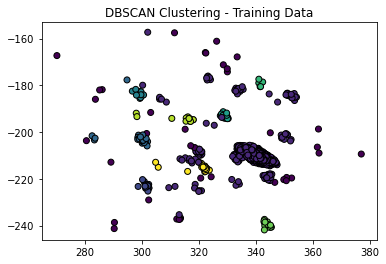

In [229]:
#summer_num

eps = 90
min_samples = 5

dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)

data = np.concatenate((summer_num_train, summer_num_test), axis=0)
len_ = len(summer_num_train)
labels = dbscan_model.fit_predict(data)
labels_train = labels[:len_]
labels_test = labels[len_:]
cluster_counts = Counter(labels)
print(cluster_counts)
# 가장 큰 클러스터 찾기
largest_cluster_label = max(cluster_counts, key=cluster_counts.get)

revised_labels = np.where(labels == largest_cluster_label, 0, 1)

plt.scatter(data[:, 0], data[:,1], c=labels, cmap='viridis', marker='o', edgecolors='k')
plt.title('DBSCAN Clustering - Training Data')
plt.show()

In [142]:
print(len_)

5987


5987
Counter({0: 8378, -1: 150, 2: 9, 4: 7, 1: 7, 3: 3})


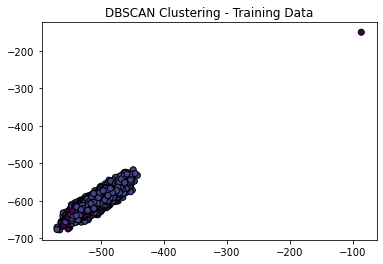

In [228]:
#summer_image

eps = 2600
min_samples = 10

dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)

data = np.concatenate((summer_image_train, summer_image_test), axis=0)
len_ = len(summer_image_train)
labels2 = dbscan_model.fit_predict(data)
print(len_)
cluster_counts = Counter(labels2)
print(cluster_counts)
# 가장 큰 클러스터 찾기
largest_cluster_label2 = max(cluster_counts, key=cluster_counts.get)

revised_labels2 = np.where(labels2 == largest_cluster_label2, 0, 1)


plt.scatter(data[:, 0], data[:,1], c=labels2, cmap='viridis', marker='o', edgecolors='k')
plt.title('DBSCAN Clustering - Training Data')
plt.show()

In [231]:
labels = revised_labels
labels2 = revised_labels2
#두개의 list를 생성해놓고 둘다 big cluster 일때만 0 아니면은 클러스터 번호로 라벨을 부여하기 
result_list = [0 if val1 == 0 and val2 == 0 else 1 for val1, val2 in zip(labels, labels2)]

summer_train_label = result_list[:len_]
summer_test_label = result_list[len_:]

cluster_counts = Counter(result_list)
print(cluster_counts)

Counter({0: 8200, 1: 354})


봄

4699
Counter({0: 6654, 3: 12, -1: 10, 4: 10, 5: 9, 1: 7, 2: 7, 6: 5})


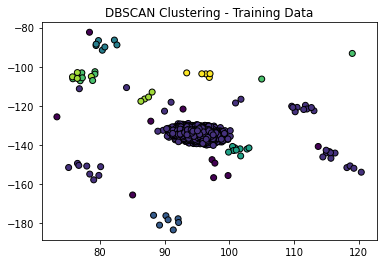

In [223]:
#spring_num

eps = 90
min_samples = 5

dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)

data = np.concatenate((spring_num_train, spring_num_test), axis=0)
len_ = len(spring_num_train)
labels3 = dbscan_model.fit_predict(data)
print(len_)
cluster_counts = Counter(labels3)
print(cluster_counts)
# 가장 큰 클러스터 찾기
largest_cluster_label = max(cluster_counts, key=cluster_counts.get)

revised_labels3 = np.where(labels3 == largest_cluster_label, 2, 3)

plt.scatter(data[:, 0], data[:,1], c=labels3, cmap='viridis', marker='o', edgecolors='k')
plt.title('DBSCAN Clustering - Training Data')
plt.show()

4699
Counter({0: 6541, -1: 143, 1: 16, 2: 14})


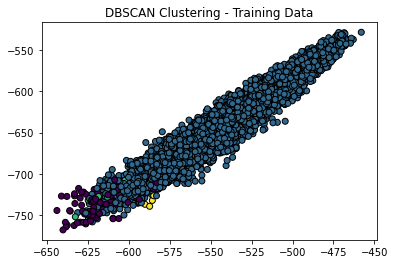

In [224]:
#spring_image

eps = 2700
min_samples = 10

dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)

data = np.concatenate((spring_image_train, spring_image_test), axis=0)
len_ = len(spring_image_train)
labels4 = dbscan_model.fit_predict(data)
print(len_)
cluster_counts = Counter(labels4)
print(cluster_counts)
# 가장 큰 클러스터 찾기
largest_cluster_label4 = max(cluster_counts, key=cluster_counts.get)

revised_labels4 = np.where(labels4 == largest_cluster_label4, 2, 3)


plt.scatter(data[:, 0], data[:,1], c=labels4, cmap='viridis', marker='o', edgecolors='k')
plt.title('DBSCAN Clustering - Training Data')
plt.show()

In [225]:
#두개의 list를 생성해놓고 둘다 big cluster 일때만 0 아니면은 클러스터 번호로 라벨을 부여하기 
labels3 = revised_labels3
labels4 = revised_labels4
result_list2 = [2 if val1 == 2 and val2 == 2 else 3 for val1, val2 in zip(labels3, labels4)]

spring_train_label = result_list2[:len_]
spring_test_label = result_list2[len_:]

cluster_counts = Counter(result_list2)
print(cluster_counts)

Counter({2: 6482, 3: 232})


가을

2992
Counter({0: 4260, 1: 9, -1: 6})


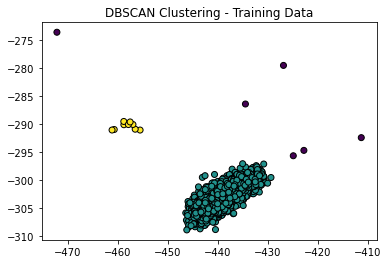

In [250]:
#fall_num

eps = 50
min_samples = 5

dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)

data = np.concatenate((fall_num_train, fall_num_test), axis=0)
len_ = len(fall_num_train)
labels5 = dbscan_model.fit_predict(data)
print(len_)
cluster_counts = Counter(labels5)
print(cluster_counts)
# 가장 큰 클러스터 찾기
largest_cluster_label = max(cluster_counts, key=cluster_counts.get)

revised_labels5 = np.where(labels5 == largest_cluster_label, 4, 5)

plt.scatter(data[:, 0], data[:,1], c=labels5, cmap='viridis', marker='o', edgecolors='k')
plt.title('DBSCAN Clustering - Training Data')
plt.show()

2992
Counter({0: 4228, -1: 38, 1: 9})


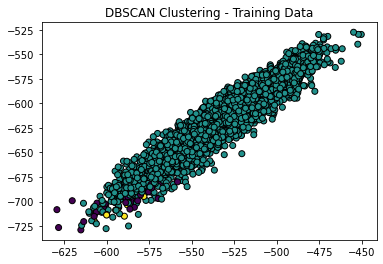

In [251]:
#fall_image

eps = 2600
min_samples = 10

dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)

data = np.concatenate((fall_image_train, fall_image_test), axis=0)
len_ = len(fall_image_train)
labels6 = dbscan_model.fit_predict(data)
print(len_)
cluster_counts = Counter(labels6)
print(cluster_counts)
# 가장 큰 클러스터 찾기
largest_cluster_label6 = max(cluster_counts, key=cluster_counts.get)

revised_labels6 = np.where(labels6 == largest_cluster_label6, 4,5)


plt.scatter(data[:, 0], data[:,1], c=labels6, cmap='viridis', marker='o', edgecolors='k')
plt.title('DBSCAN Clustering - Training Data')
plt.show()

In [252]:
#두개의 list를 생성해놓고 둘다 big cluster 일때만 0 아니면은 클러스터 번호로 라벨을 부여하기 
labels5 = revised_labels5
labels6 = revised_labels6

result_list3 = [4 if val1 == 4 and val2 == 4 else 5 for val1, val2 in zip(labels5, labels6)]

fall_train_label = result_list3[:len_]
fall_test_label = result_list3[len_:]

cluster_counts = Counter(result_list3)
print(cluster_counts)

Counter({4: 4213, 5: 62})


겨울

4340
Counter({0: 6188, 1: 9, -1: 4})


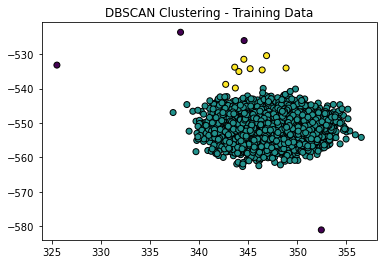

In [253]:
#winter_num

eps = 47
min_samples = 7

dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)

data = np.concatenate((winter_num_train, winter_num_test), axis=0)
len_ = len(winter_num_train)
labels7 = dbscan_model.fit_predict(data)
print(len_)
cluster_counts = Counter(labels7)
print(cluster_counts)
# 가장 큰 클러스터 찾기
largest_cluster_label = max(cluster_counts, key=cluster_counts.get)

revised_labels7 = np.where(labels7 == largest_cluster_label, 6, 7)

plt.scatter(data[:, 0], data[:,1], c=labels7, cmap='viridis', marker='o', edgecolors='k')
plt.title('DBSCAN Clustering - Training Data')
plt.show()

4340
Counter({0: 6143, -1: 58})


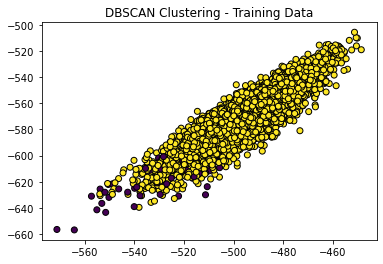

In [254]:
#winter_image

eps = 1800
min_samples = 10

dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)

data = np.concatenate((winter_image_train, winter_image_test), axis=0)
len_ = len(winter_image_train)
labels8 = dbscan_model.fit_predict(data)
print(len_)
cluster_counts = Counter(labels8)
print(cluster_counts)
# 가장 큰 클러스터 찾기
largest_cluster_label8 = max(cluster_counts, key=cluster_counts.get)

revised_labels8 = np.where(labels8 == largest_cluster_label8, 6, 7)


plt.scatter(data[:, 0], data[:,1], c=labels8, cmap='viridis', marker='o', edgecolors='k')
plt.title('DBSCAN Clustering - Training Data')
plt.show()

In [256]:
#두개의 list를 생성해놓고 둘다 big cluster 일때만 0 아니면은 클러스터 번호로 라벨을 부여하기 
labels7 = revised_labels7
labels8 = revised_labels8


result_list4 = [6 if val1 == 6 and val2 == 6 else 7 for val1, val2 in zip(labels7, labels8)]

winter_train_label = result_list4[:len_]
winter_test_label = result_list4[len_:]

cluster_counts = Counter(result_list4)
print(cluster_counts)

Counter({6: 6130, 7: 71})


# 5. Randomforest 학습하기 

train과 test 모두 합치기..대박.. 대신, label주면서 합치기..헐.. 
summer,winter,spring,fall train,test 합치기

In [257]:
array1 = np.array([1, 2, 3])
array2 = np.array([4, 5, 6])
array3 = np.array([7, 8, 9])
array4 = np.array([10, 11, 12])

# 4개의 배열을 연결
result_array = np.concatenate((array1, array2, array3, array4))

# 결과 출력
print(result_array)

[ 1  2  3  4  5  6  7  8  9 10 11 12]


In [281]:
train_x = np.concatenate((summer_num_train,spring_num_train,fall_num_train,winter_num_train))
train_y = np.concatenate((summer_train_label,spring_train_label,fall_train_label,winter_train_label))
test_x = np.concatenate((summer_num_test,spring_num_test,fall_num_test,winter_num_test))
test_y = np.concatenate((summer_test_label,spring_test_label,fall_test_label,winter_test_label))

In [ ]:
with open ()

In [282]:
train_len = len(train_y)
test_len = len(test_y)
random_indices = np.random.permutation(train_len)
random_indices2= np.random.permutation(test_len)

# 생성된 랜덤 인덱스를 사용하여 두 배열 섞기
train_x = train_x[random_indices]
train_y = train_y[random_indices]
test_x = test_x[random_indices2]
test_y = test_y[random_indices2]

In [259]:
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [291]:
rf_model = RandomForestClassifier(random_state = 108,n_estimators = 500)
rf_model.fit(train_x, train_y)

RandomForestClassifier(n_estimators=500, random_state=108)

In [243]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report


def score(labels, pred):
    confusion = confusion_matrix(labels, pred)
    accuracy = accuracy_score(labels, pred)
    precision = precision_score(labels, pred, average='macro')
    recall = recall_score(labels, pred, average='macro')
    f1 = f1_score(labels, pred, average='macro')
    print(classification_report(labels, pred))
    print('Confusion Matrix')
    print(confusion)
    print('정확도:{:.3f}, 정밀도:{:.3f}, 재현율:{:.3f}, F1-Socre:{:.3f}'.format(accuracy, precision, recall, f1))

In [293]:
predict = rf_model.predict(test_x) 

In [290]:
score(test_y, predict)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2461
           1       0.89      0.46      0.61       106
           2       0.97      1.00      0.99      1950
           3       0.94      0.23      0.37        65
           4       0.99      1.00      1.00      1267
           5       1.00      0.25      0.40        16
           6       0.99      1.00      0.99      1837
           7       1.00      0.12      0.22        24

    accuracy                           0.98      7726
   macro avg       0.97      0.63      0.70      7726
weighted avg       0.98      0.98      0.98      7726

Confusion Matrix
[[2455    6    0    0    0    0    0    0]
 [  57   49    0    0    0    0    0    0]
 [   0    0 1949    1    0    0    0    0]
 [   0    0   50   15    0    0    0    0]
 [   0    0    0    0 1267    0    0    0]
 [   0    0    0    0   12    4    0    0]
 [   0    0    0    0    0    0 1837    0]
 [   0    0    0    0    0    0

계절만 하기

In [304]:
selected_indices = np.where(train_y % 2 == 0)[0]
selected_indices2 = np.where(test_y % 2 == 0)[0]

train_x2 = train_x[selected_indices]
test_x2 = test_x[selected_indices2]
train_y2 = train_y[selected_indices]
test_y2 = test_y[selected_indices2]

In [305]:
rf_model2 = RandomForestClassifier(random_state = 108,n_estimators = 200)
rf_model2.fit(train_x2, train_y2)

RandomForestClassifier(n_estimators=200, random_state=108)

In [306]:
predict2 = rf_model2.predict(test_x2) 

In [313]:
len(train_x2[0])

32

In [307]:
score(test_y2, predict2)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2461
           2       1.00      1.00      1.00      1950
           4       1.00      1.00      1.00      1267
           6       1.00      1.00      1.00      1837

    accuracy                           1.00      7515
   macro avg       1.00      1.00      1.00      7515
weighted avg       1.00      1.00      1.00      7515

Confusion Matrix
[[2461    0    0    0]
 [   0 1950    0    0]
 [   0    0 1267    0]
 [   0    0    0 1837]]
정확도:1.000, 정밀도:1.000, 재현율:1.000, F1-Socre:1.000


In [ ]:
rf_model2

In [310]:
with open('saved_model2','wb') as f:
    pickle.dump(rf_model2,f)

In [311]:
with open(f'train_x2.pickle', 'wb') as f:
    pickle.dump(train_x2, f)
with open(f'test_x2.pickle', 'wb') as f:
    pickle.dump(test_x2, f)
with open(f'train_y2.pickle', 'wb') as f:
    pickle.dump(train_y2, f)
with open(f'test_y2.pickle', 'wb') as f:
    pickle.dump(test_y2, f)

112차원으로 학습

In [316]:
summer_data2 = []
spring_data2 = []
winter_data2 = []
fall_data2 = []

In [338]:
len(summer_data)

8554

In [339]:
summer_data2 = []
for data_ in summer_data:
    summer_data2.append(data_[2])


In [ ]:
for data_ in spring_data:
    spring_data2.append(data_[2])
for data_ in fall_data:
    fall_data2.append(data_[2])
for data_ in winter_data:
    winter_data2.append(data_[2])

In [354]:
train_x_n2 = summer_data2[:5987] + spring_data2[:4699] + fall_data2[:2992] + winter_data2[:4340]
test_x_n2 = summer_data2[5987:] + spring_data2[4699:] + fall_data2[2992:] + winter_data2[4340:]

In [341]:
count_0 = 5987
count_2 = 4699
count_4 = 2992
count_6 = 4340

In [344]:
count_0 = 2567
count_2 = 2015
count_4 = 1283
count_6 = 1861

In [342]:
print(len(summer_data2[5987:]))
print(len(spring_data2[4699:]))
print(len(fall_data2[2992:]))
print(len(winter_data2[4340:]))

2567
2015
1283
1861


In [343]:
train_y_n = np.concatenate([
    np.zeros(count_0),
    np.full(count_2, 2),
    np.full(count_4, 4),
    np.full(count_6, 6)
])

In [343]:
train_y_n = np.concatenate([
    np.zeros(count_0),
    np.full(count_2, 2),
    np.full(count_4, 4),
    np.full(count_6, 6)
])

In [345]:
test_y_n = np.concatenate([
    np.zeros(count_0),
    np.full(count_2, 2),
    np.full(count_4, 4),
    np.full(count_6, 6)
])

In [347]:
train_x_n = np.array(train_x_n)
test_x_n = np.array(test_x_n)

In [ ]:
train_y_n = [
test_y_n = 

In [376]:
train_x_n2 = np.array(train_x_n2)

In [378]:
test_x_n2 = np.array(test_x_n2)

In [372]:
selected_indices = np.where(train_y % 2 == 1)[0].astype(int)
selected_indices2 = np.where(test_y % 2 == 1)[0].astype(int)

In [370]:
len(train_x_n2)

18018

In [371]:
len(train_y)

18018

In [383]:
train_x_n = train_x_n2[selected_indices]
test_x_n = test_x_n2[selected_indices2]
train_y_n = train_y[selected_indices]
test_y_n = test_y[selected_indices2]

In [364]:
#train_x = np.concatenate((summer_num_train,spring_num_train,fall_num_train,winter_num_train))
train_y = np.concatenate((summer_train_label,spring_train_label,fall_train_label,winter_train_label))
#test_x = np.concatenate((summer_num_test,spring_num_test,fall_num_test,winter_num_test))
test_y = np.concatenate((summer_test_label,spring_test_label,fall_test_label,winter_test_label))

In [333]:
test_y_n[:10]

array([0, 0, 0, 0, 2, 0, 2, 4, 6, 0])

In [349]:
rf_model_n = RandomForestClassifier(random_state = 108,n_estimators = 100)
rf_model_n.fit(train_x_n, train_y_n)

RandomForestClassifier(random_state=108)

In [352]:
with open('saved_model_n','wb') as f:
    pickle.dump(rf_model_n,f)

In [384]:
predict_n = rf_model_n.predict(test_x_n) 

In [386]:
predict_n2 = rf_model_n.predict(train_x_n) 

In [385]:
score(test_y_n, predict_n)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00     106.0
         2.0       0.00      0.00      0.00       0.0
         3.0       0.00      0.00      0.00      65.0
         4.0       0.00      0.00      0.00       0.0
         5.0       0.00      0.00      0.00      16.0
         6.0       0.00      0.00      0.00       0.0
         7.0       0.00      0.00      0.00      24.0

    accuracy                           0.00     211.0
   macro avg       0.00      0.00      0.00     211.0
weighted avg       0.00      0.00      0.00     211.0

Confusion Matrix
[[  0   0   0   0   0   0   0   0]
 [103   0   3   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  8   0  53   0   4   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  3   0   3   0  10   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   2   0   0   0  22   0]]
정확도:0.000, 정밀도:0.000, 재현율:0.000, F1-Socre:0.000


C:\Users\youna\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\youna\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\youna\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\youna\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: Undef

In [388]:
score(train_y_n, predict_n2)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00     248.0
         2.0       0.00      0.00      0.00       0.0
         3.0       0.00      0.00      0.00     167.0
         4.0       0.00      0.00      0.00       0.0
         5.0       0.00      0.00      0.00      46.0
         6.0       0.00      0.00      0.00       0.0
         7.0       0.00      0.00      0.00      47.0

    accuracy                           0.00     508.0
   macro avg       0.00      0.00      0.00     508.0
weighted avg       0.00      0.00      0.00     508.0

Confusion Matrix
[[  0   0   0   0   0   0   0   0]
 [247   0   1   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  1   0 166   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0  46   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  47   0]]
정확도:0.000, 정밀도:0.000, 재현율:0.000, F1-Socre:0.000


C:\Users\youna\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\youna\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\youna\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\youna\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: Undef

In [381]:
predict_dt = dt.predict(test_x_n) 

In [382]:
score(test_y_n, predict_dt)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00     106.0
         2.0       0.00      0.00      0.00       0.0
         3.0       0.00      0.00      0.00      65.0
         4.0       0.00      0.00      0.00       0.0
         5.0       0.00      0.00      0.00      16.0
         6.0       0.00      0.00      0.00       0.0
         7.0       0.00      0.00      0.00      24.0

    accuracy                           0.00     211.0
   macro avg       0.00      0.00      0.00     211.0
weighted avg       0.00      0.00      0.00     211.0

Confusion Matrix
[[  0   0   0   0   0   0   0   0]
 [102   0   4   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [ 27   0  35   0   2   0   1   0]
 [  0   0   0   0   0   0   0   0]
 [  5   0   6   0   4   0   1   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   2   0   3   0  19   0]]
정확도:0.000, 정밀도:0.000, 재현율:0.000, F1-Socre:0.000


C:\Users\youna\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\youna\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\youna\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\youna\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: Undef

# 6. decision tree 학습하기

In [353]:
with open(f'train_x_n.pickle', 'wb') as f:
    pickle.dump(train_x_n, f)
with open(f'test_x_n.pickle', 'wb') as f:
    pickle.dump(test_x_n, f)
with open(f'train_y_n.pickle', 'wb') as f:
    pickle.dump(train_y_n, f)
with open(f'test_y_n.pickle', 'wb') as f:
    pickle.dump(test_y_n, f)

# import turstee

In [ ]:
#X, y = datasets.load_iris(return_X_y=True)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

#clf = RandomForestClassifier(n_estimators=100)
#clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)

trustee = ClassificationTrustee(expert=rf_model)
trustee.fit(np.array(train_x), train_y, num_iter=50, num_stability_iter=10, samples_size=0.3, verbose=True)
dt, pruned_dt, agreement, reward = trustee.explain()

In [ ]:
graph = graphviz.Source(dot_data)
graph.render("decision_tree", format="png", cleanup=True)  # "decision_tree.png"로 저장
graph.view("decision_tree")  # 시각화 창 열기

In [380]:
with open(r'E:\대학원1-1\인공지능보안\prunned_model', 'rb') as f:
    dt = pickle.load(f)

그래프로 노드 확인하기

이상치 년도별로 확인하기